In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from time import time

In [2]:
def d1(St, K, T, t, r, q, sigma):
    return (np.log(St/K) + (r -q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

def d2(St, K, T, t, r, q, sigma):
    return (np.log(St/K) + (r - q - sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

def BSMcall(St, K, T, t, r, q, sigma):
    """
    St: Stock price at time t
    t: reference time
    T: time to maturity
    r: risk free rate
    q : dividend rate
    sigma: volatility
    """
    _d1 = sp.special.ndtr(d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(d2(St, K, T, t, r, q, sigma))

    return St*np.exp(-q*(T-t))*_d1 - K*np.exp(-r*(T-t))*_d2

def BSMdigitalCall(St, K, T, t, r, q, sigma):
    return np.exp(-r*(T-t))*sp.special.ndtr(d2(St, K, T, t, r, q, sigma))

def BSMput(St, K, T, t, r, q, sigma):
    _d1 = sp.special.ndtr(-d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(-d2(St, K, T, t, r, q, sigma))

    return K*np.exp(-r*(T-t))*_d2 - St*np.exp(-q*(T-t))*_d1

def BSMdigitalPut(St, K, T, t, r, q, sigma):
    return np.exp(-r*(T-t))*sp.special.ndtr(-d2(St, K, T, t, r, q, sigma))

def BSMforwardPrice(St, K, T, t, r, q):
    return St*np.exp(-q*(T-t)) - K*np.exp(-r*(T-t))

def BSMzeroCouponBondPrice(T, t, r):
    return np.exp(-r*(T-t))


# Binary Trees algorithm

Geometric Brownian Motion

$d(\log S) = (r-\sigma^2/2)\Delta t + \sigma \sqrt{\Delta t} dW$.

For each time step $\Delta t$ the $\log S$ evolves by $(r-\sigma^2/2)\Delta t$ and goes either $⇑$ or $↓$ by $\sigma \sqrt{\Delta t}$.

In [3]:
class BinomialTree:
    def __init__(self, S0, T, r, q, sigma, noSteps):
        self.r = r
        self.q = q
        self.T = T
        self.noSteps = noSteps
        self.dt = T/(noSteps - 1)
        self.drift = (r-q-sigma**2/2)*self.dt
        self.randomInc = sigma*np.sqrt(self.dt)
        self.layers = [np.zeros(i+1) for i in range(noSteps)]
        self.layers[0][0] = S0

        self.split()

    name = 'Binomial Tree'

    def split(self):

        for i in range(1, self.noSteps):

            for j in range(i+1):

                self.layers[i][j] = self.layers[i-1][0]*np.exp(-self.randomInc + 2*j*self.randomInc)

            self.layers[i][:]*= np.exp(self.drift)

    def evaluateOption(self, optionPayoff, filterFn = None ):

        prevLayer = optionPayoff(self.layers[-1])
        currLayer = np.zeros(prevLayer.size - 1)

        while currLayer.size > 0:

            for j in range(currLayer.size):

                if filterFn is not None:
                    prevLayer*= filterFn(self.layers[prevLayer.size-1])

                currLayer[j] = np.exp(-self.r*self.dt)*(prevLayer[j] + prevLayer[j+1])/2

            prevLayer = currLayer
            currLayer = np.zeros(prevLayer.size - 1)

        return prevLayer[0]


    def evaluateAmericanPut(self, K):

        prevLayer = np.maximum(K - self.layers[-1],0)
        currLayer = np.zeros(prevLayer.size - 1)

        while currLayer.size > 0:

            for j in range(currLayer.size):
                currLayer[j] = np.maximum(np.exp(-self.r*self.dt)*(prevLayer[j] + prevLayer[j+1])/2, K-self.layers[currLayer.size][j])

            prevLayer = currLayer
            currLayer = np.zeros(prevLayer.size - 1)

        return prevLayer[0]

In [4]:
def EuropeanCallOptionPayoff(array, K):
    return np.maximum(array - K,0)

def EuropeanPutOptionPayoff(array, K):
    return np.maximum(K - array,0)

def ForwardPayoff(array, K):
    return array - K

def DigitalCallOptionPayoff(array, K):
    return (array > K)*np.ones(array.shape)

def KnockOutCallOption(array, K):
    return max(array)> K



In [5]:
def checkConvergence(derivativeName, derivativePayoff, analyticalValue, TreeClass = BinomialTree):

    _array = np.zeros(maxPower - minPower)
    for idx,_power in enumerate(range(minPower,maxPower)):
        noSteps = 2**_power
        sT = TreeClass(S0, T, r, q, sigma, noSteps)
        _array[idx] = sT.evaluateOption(derivativePayoff)


    print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}, sigma = {sigma :.2f}')
    fig,ax = plt.subplots(1,1, figsize=(6,5))
    ax.plot(np.power(2,np.arange(minPower,maxPower)), _array, label = f'{TreeClass.name} {derivativeName} Option')
    ax.set_xlabel(r'No of steps')
    ax.set_ylabel(f'{derivativeName} Option Price')
    ax.set_title(f'{TreeClass.name} {derivativeName} Option Approximation vs Number of Steps')
    if(analyticalValue!=None):
        ax.hlines(y=analyticalValue, color = 'red', xmin =0, xmax = np.power(2,maxPower-1), label = 'Analytical value')
    ax.legend()


In [6]:
def checkAmericanPutConvergence(K):
    _array = np.zeros(maxPower - minPower)
    for idx,_power in enumerate(range(minPower,maxPower)):
        noSteps = 2**_power
        sT = BinomialTree(S0, T, r, q, sigma, noSteps)
        _array[idx] = sT.evaluateAmericanPut(K)

    print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}, sigma = {sigma :.2f}')
    fig,ax = plt.subplots(1,1)
    ax.plot(stepsArray,_array)
    ax.set_xlabel(r'No of steps')
    ax.set_ylabel('American Put Option Price')
    ax.set_title('Binomial Tree American Put Option Approximation vs Number of Steps')

In [7]:
def checkAvgAmericanPutConvergence(K):
    _array = np.zeros(maxPower - minPower)
    for idx,_power in enumerate(range(minPower,maxPower)):
        noSteps = 2**_power
        sT1 = BinomialTree(S0, T, r, q, sigma, noSteps)
        _deriv1 = sT1.evaluateAmericanPut(K)
        sT2 = BinomialTree(S0, T, r, q, sigma, noSteps+1)
        _deriv2 = sT2.evaluateAmericanPut(K)
        _array[idx] = (_deriv1 + _deriv2)/2

    print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}, sigma = {sigma :.2f}')
    fig,ax = plt.subplots(1,1)
    ax.plot(stepsArray,_array)
    ax.set_xlabel(r'No of steps')
    ax.set_ylabel('American Put Option Price')
    ax.set_title('Binomial Tree American Put Option Avg Approximation (over N, N+1 steps) vs Number of Steps')

In [8]:
def checkAvgConvergence(derivativeName, derivativePayoff, analyticalValue, TreeClass = BinomialTree):
    _array = np.zeros(maxPower - minPower)
    for idx,_power in enumerate(range(minPower,maxPower)):
        noSteps = 2**_power
        sT1 = TreeClass(S0, T, r, q, sigma, noSteps)
        _deriv1 = sT1.evaluateOption(derivativePayoff)
        sT2 = TreeClass(S0, T, r, q, sigma, noSteps+1)
        _deriv2 = sT2.evaluateOption(derivativePayoff)
        _array[idx] = (_deriv1 + _deriv2)/2

    print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}, sigma = {sigma :.2f}')
    fig,ax = plt.subplots(1,1)
    ax.plot(stepsArray,_array)
    ax.set_xlabel(r'No of steps')
    ax.set_ylabel(f'{derivativeName} Option Price')
    ax.set_title(f'Binomial Tree {derivativeName} Option Average (over N, N+1 steps) vs Number of Steps')
    if(analyticalValue!=None):
        ax.hlines(y=analyticalValue, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))

In [9]:
t = 0
T = 2
K = 100
S0 = 100
q = 0.0
sigma = .1
r = .05
B = 80
epsilon = 1e-6

In [34]:
minPower = 5
maxPower = 11

In [35]:
stepsArray = np.power(2,np.arange(minPower, maxPower))

In [36]:
sT = BinomialTree(S0, T, r, q, sigma, noSteps = np.power(2,maxPower))

## Computing Convergence of European Call Price via Binomial Tree

Using parameters: r = 0.05, q = 0.00, t = 0.00 years, T = 2.00 years, S0 = 100.00, K = 100.00, sigma = 0.10


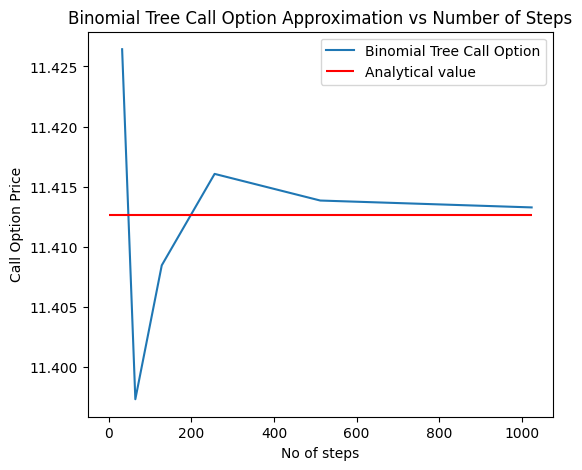

In [13]:
checkConvergence(derivativeName='Call', derivativePayoff= lambda x : EuropeanCallOptionPayoff(x,K),analyticalValue= BSMcall(S0, K, T, 0, r, q, sigma), TreeClass = BinomialTree)

In [14]:
binaryTreecall = sT.evaluateOption(lambda x : EuropeanCallOptionPayoff(x,K))
call = BSMcall(S0, K, T, 0, r, q, sigma)
d = (binaryTreecall - call)/call
print(f'The discrepancy of binary Tree Call to Analytical Call price is {d*100:.2f} %')

The discrepancy of binary Tree Call to Analytical Call price is -0.00 %


Using parameters: r = 0.05, q = 0.00, t = 0.00 years, T = 2.00 years, S0 = 100.00, K = 100.00, sigma = 0.10


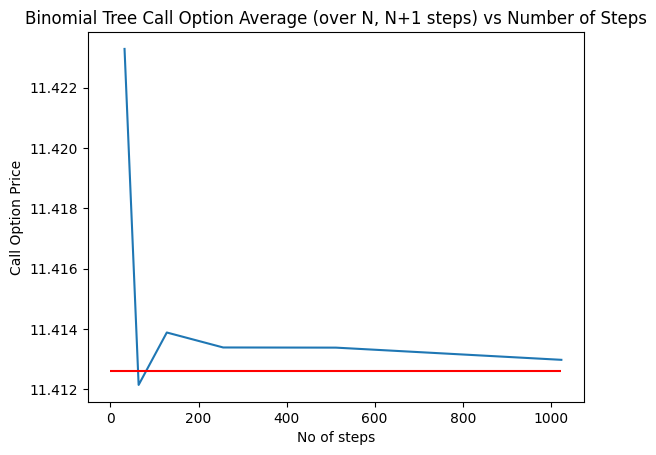

In [15]:
checkAvgConvergence('Call', lambda x : EuropeanCallOptionPayoff(x,K), BSMcall(S0, K, T, 0, r, q, sigma))

Convergence is improved when averaging

Using parameters: r = 0.05, q = 0.00, t = 0.00 years, T = 2.00 years, S0 = 100.00, K = 100.00, sigma = 0.10


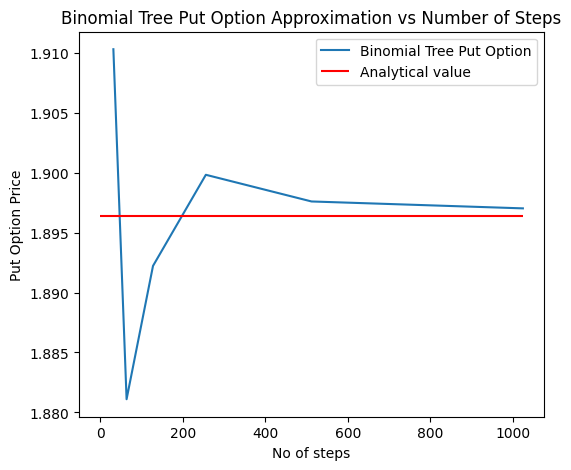

In [16]:
checkConvergence('Put', lambda x : EuropeanPutOptionPayoff(x,K), BSMput(S0, K, T, 0, r, q, sigma))

In [17]:
binaryTreePut = sT.evaluateOption(lambda x : EuropeanPutOptionPayoff(x,K))
put = BSMput(S0, K, T, 0, r, q, sigma)
d = (binaryTreePut - put)/put
print(f'The discrepancy of binary Tree Put to Analytical Put price is {d*100:.2f} %')

The discrepancy of binary Tree Put to Analytical Put price is -0.01 %


Using parameters: r = 0.05, q = 0.00, t = 0.00 years, T = 2.00 years, S0 = 100.00, K = 100.00, sigma = 0.10


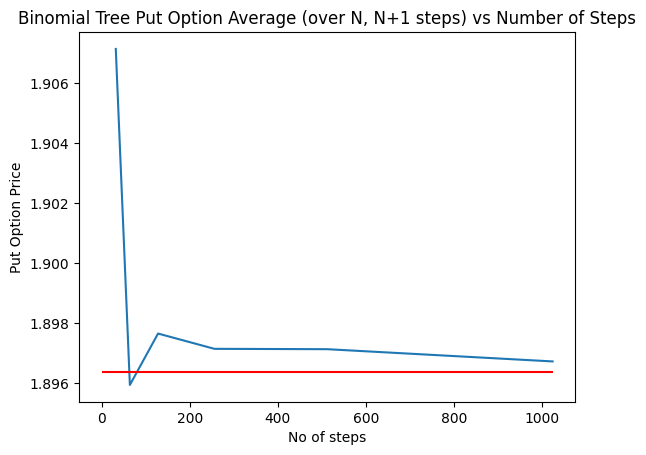

In [18]:
checkAvgConvergence('Put', lambda x : EuropeanPutOptionPayoff(x,K), BSMput(S0, K, T, 0, r, q, sigma))

Using parameters: r = 0.05, q = 0.00, t = 0.00 years, T = 2.00 years, S0 = 100.00, K = 100.00, sigma = 0.10


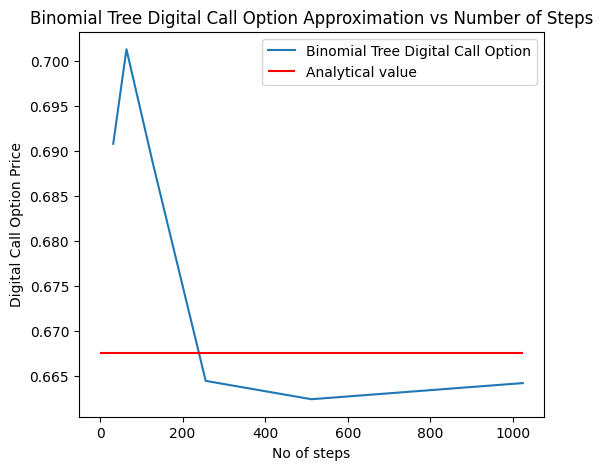

In [20]:
checkConvergence('Digital Call', lambda x : DigitalCallOptionPayoff(x,K), BSMdigitalCall(S0, K, T, 0, r, q, sigma))

In [21]:
binaryTreeDigitalCall = sT.evaluateOption(lambda x : DigitalCallOptionPayoff(x,K))
digiCall = BSMdigitalCall(S0, K, T, 0, r, q, sigma)
d = (binaryTreeDigitalCall - digiCall)/digiCall
print(f'The discrepancy of binary Tree Digital Call to Analytical Digital Call price is {d*100:.2f} %')

The discrepancy of binary Tree Digital Call to Analytical Digital Call price is -0.78 %


Using parameters: r = 0.05, q = 0.00, t = 0.00 years, T = 2.00 years, S0 = 100.00, K = 100.00, sigma = 0.10


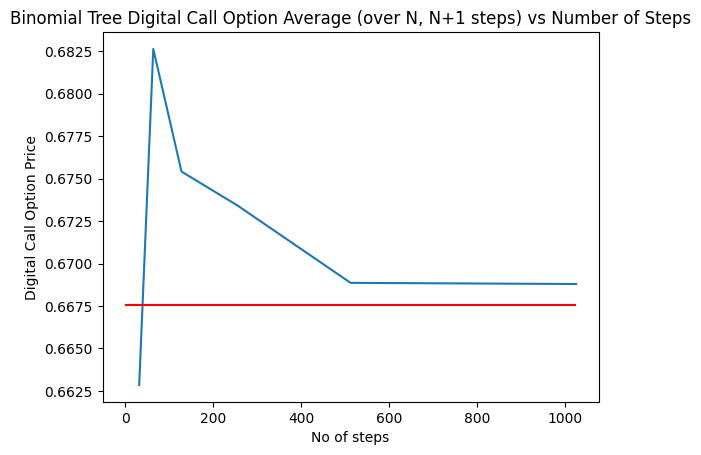

In [22]:
checkAvgConvergence('Digital Call', lambda x : DigitalCallOptionPayoff(x,K), BSMdigitalCall(S0, K, T, 0, r, q, sigma))

Using parameters: r = 0.05, q = 0.00, t = 0.00 years, T = 2.00 years, S0 = 100.00, K = 100.00, sigma = 0.10


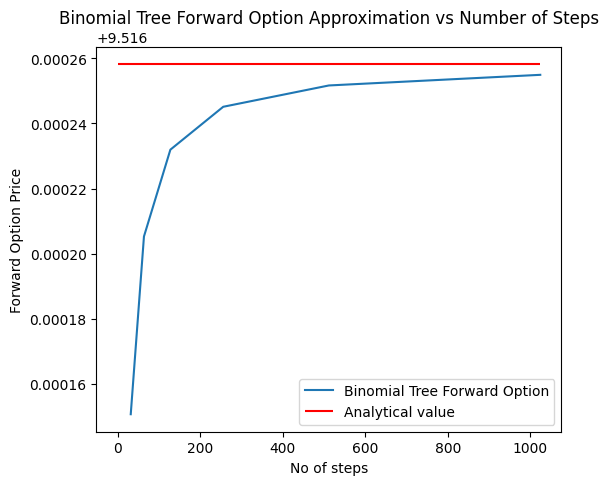

In [23]:
checkConvergence('Forward', lambda x : ForwardPayoff(x,K), BSMforwardPrice(S0, K, T, 0, r, q))

In [24]:
binaryTreeForward = sT.evaluateOption(lambda x : ForwardPayoff(x,K))
forward = BSMforwardPrice(S0, K, T, 0, r, q)
d = (binaryTreeForward - forward)/forward
print(f'The discrepancy of binary Tree Forward to Analytical Forward price is {d*100:.2f} %')

The discrepancy of binary Tree Forward to Analytical Forward price is -0.00 %


Using parameters: r = 0.05, q = 0.00, t = 0.00 years, T = 2.00 years, S0 = 100.00, K = 100.00, sigma = 0.10


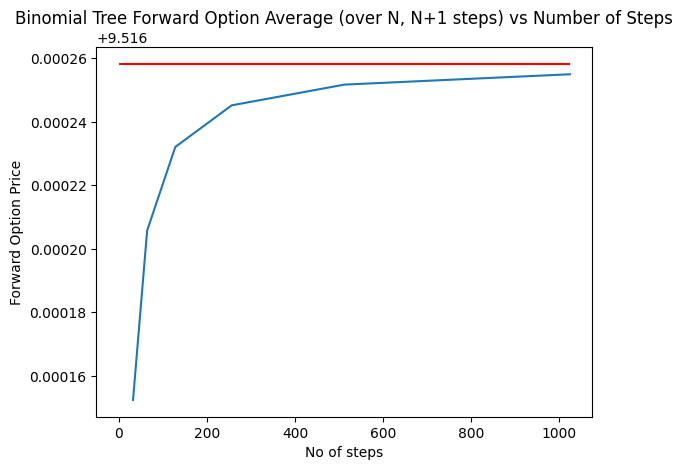

In [25]:
checkAvgConvergence('Forward', lambda x : ForwardPayoff(x,K), BSMforwardPrice(S0, K, T, 0, r, q))

# Evaluating a Down and out Barrier Option with barrier level at B = 95

In [31]:
B = 95

In [32]:
binaryTreeDownOutCall = sT.evaluateOption(optionPayoff = lambda x : (x > B)*np.maximum(x - K,0), filterFn = lambda x : x > B)

Using parameters: r = 0.05, q = 0.00, t = 0.00 years, T = 2.00 years, S0 = 100.00, K = 100.00, sigma = 0.10


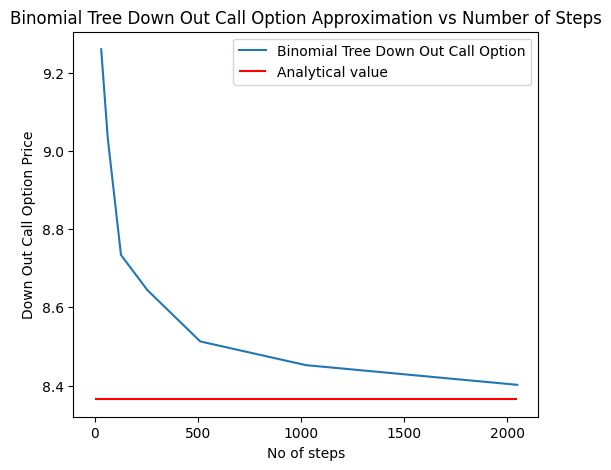

In [33]:
_array = np.zeros(maxPower - minPower)
for idx,_power in enumerate(range(minPower,maxPower)):
    noSteps = 2**_power
    sT = BinomialTree(S0, T, r, q, sigma, noSteps)
    _array[idx] = sT.evaluateOption(optionPayoff = lambda x : (x > B)*np.maximum(x - K,0), filterFn = lambda x : x > B)


print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}, sigma = {sigma :.2f}')
fig,ax = plt.subplots(1,1, figsize=(6,5))
ax.plot(np.power(2,np.arange(minPower,maxPower)), _array, label = f'{BinomialTree.name} Down Out Call Option')
ax.set_xlabel(r'No of steps')
ax.set_ylabel(f'Down Out Call Option Price')
ax.set_title(f'{BinomialTree.name} Down Out Call Option Approximation vs Number of Steps')
ax.hlines(y=binaryTreeDownOutCall, color = 'red', xmin =0, xmax = np.power(2,maxPower-1), label = 'Analytical value')
ax.legend()

In [37]:
downOutCall = 8.28 # Value was obtained using online calculators
d = (binaryTreeDownOutCall - downOutCall)/downOutCall
print(f'The discrepancy of binary Tree Down and Out Call Option to Monte Carlo Down and Out price is {d*100:.2f} %')

The discrepancy of binary Tree Down and Out Call Option to Monte Carlo Down and Out price is 1.03 %


Using parameters: r = 0.05, q = 0.00, t = 0.00 years, T = 2.00 years, S0 = 100.00, K = 100.00, sigma = 0.10, B = 95.00


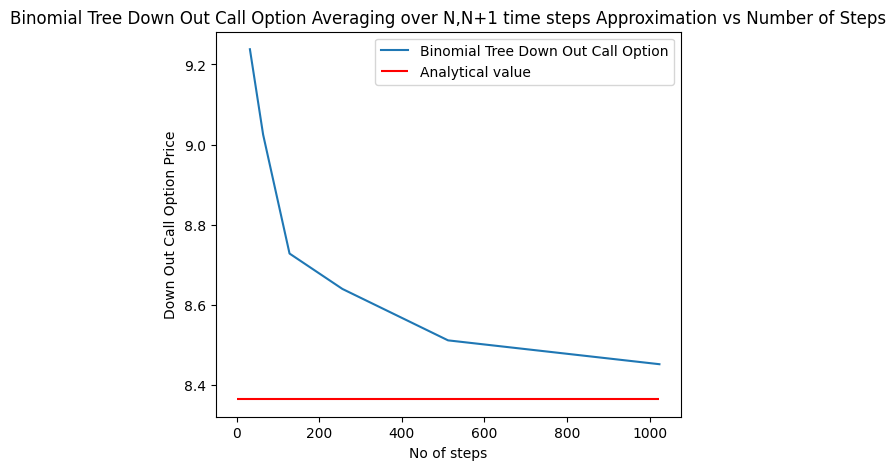

In [40]:
_array = np.zeros(maxPower - minPower)
for idx,_power in enumerate(range(minPower,maxPower)):
    noSteps = 2**_power
    sT1 = BinomialTree(S0, T, r, q, sigma, noSteps)
    sT2 = BinomialTree(S0, T, r, q, sigma, noSteps+1)
    _deriv1 = sT1.evaluateOption(optionPayoff = lambda x : (x > B)*np.maximum(x - K,0), filterFn = lambda x : x > B)
    _deriv2 = sT2.evaluateOption(optionPayoff = lambda x : (x > B)*np.maximum(x - K,0), filterFn = lambda x : x > B)
    _array[idx] = (_deriv1 + _deriv2)/2

print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}, sigma = {sigma :.2f}, B = {B:.2f}')
fig,ax = plt.subplots(1,1, figsize=(6,5))
ax.plot(np.power(2,np.arange(minPower,maxPower)), _array, label = f'{BinomialTree.name} Down Out Call Option')
ax.set_xlabel(r'No of steps')
ax.set_ylabel(f'Down Out Call Option Price')
ax.set_title(f'{BinomialTree.name} Down Out Call Option Averaging over N,N+1 time steps Approximation vs Number of Steps')
ax.hlines(y=binaryTreeDownOutCall, color = 'red', xmin =0, xmax = np.power(2,maxPower-1), label = 'Analytical value')
ax.legend()

The convergence is similarly improved when averaging over consecutive number of steps

In [44]:
K = 85
sigma = .25
sT = BinomialTree(S0, T, r, q, sigma, np.power(2,maxPower-1))

Using parameters: r = 0.05, q = 0.00, t = 0.00 years, T = 2.00 years, S0 = 100.00, K = 85.00, sigma = 0.25


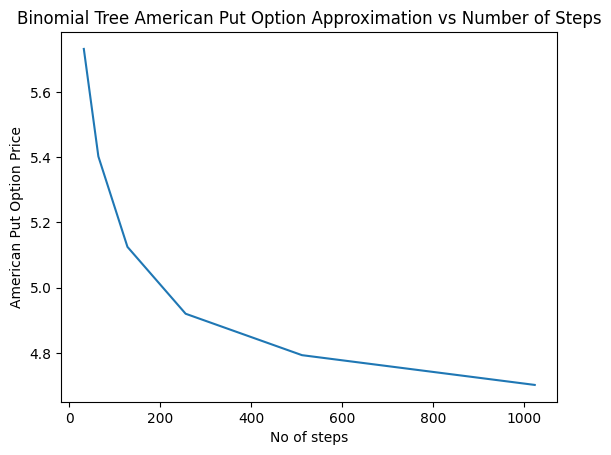

In [42]:
checkAmericanPutConvergence(K)

In [45]:
binaryTreeAmericanPut = sT.evaluateAmericanPut(K)
americanPut = 4.58 # Value was obtained using online calculators
d = (binaryTreeAmericanPut - americanPut)/americanPut
print(f'The discrepancy of binary Tree American Put to Monte Carlo American Put price is {d*100:.2f} %')

The discrepancy of binary Tree American Put to Monte Carlo American Put price is 2.65 %


Using parameters: r = 0.05, q = 0.00, t = 0.00 years, T = 2.00 years, S0 = 100.00, K = 85.00, sigma = 0.25


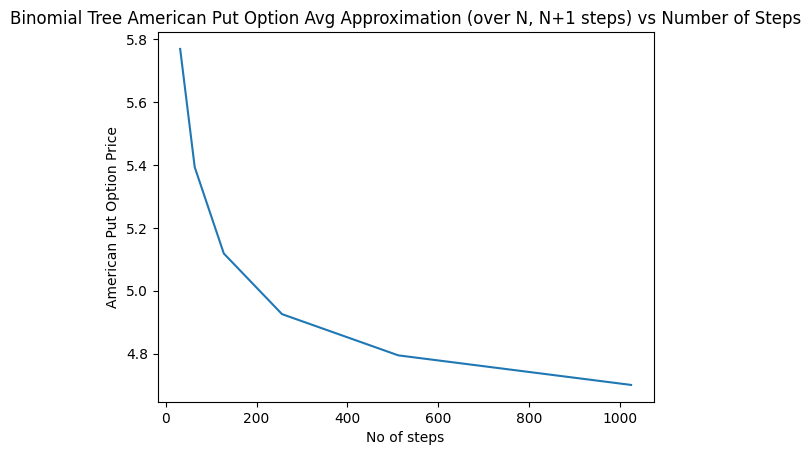

In [ ]:
checkAvgAmericanPutConvergence(K)

## Check convergence of a far out of the money option

Take $K = 50$

In [ ]:
t = 0
T = 2
K = 75
S0 = 100
q = 0.0
sigma = .1
r = .05
B = 80
sT = BinomialTree(S0, T, r, q, sigma, np.power(2,maxPower-1))

Using parameters: r = 0.05, q = 0.00, t = 0.00 years, T = 2.00 years, S0 = 100.00, K = 75.00, sigma = 0.10


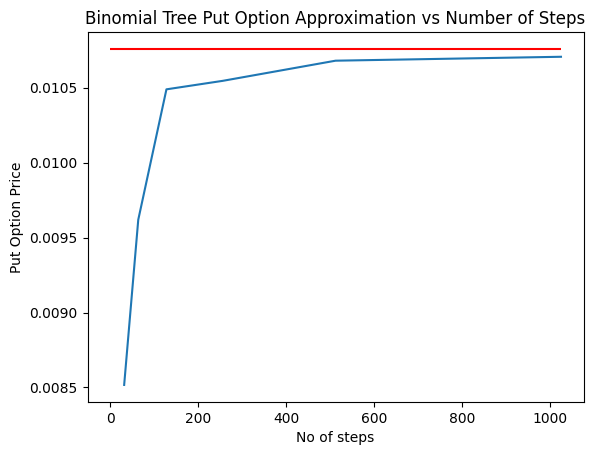

In [ ]:
checkConvergence('Put', lambda x : EuropeanPutOptionPayoff(x,K), BSMput(S0, K, T, 0, r, q, sigma))

In [ ]:
binaryTreePut = sT.evaluateOption(lambda x : EuropeanPutOptionPayoff(x,K))
put = BSMput(S0, K, T, 0, r, q, sigma)
d = (binaryTreePut - put)/put
print(f'The discrepancy of binary Tree Put to Analytical Put price is {d*100:.2f} %')

The discrepancy of binary Tree Put to Analytical Put price is -0.49 %


## The convergence of of a far out of the money Put is worse

#TRINOMIAL TREE

Implementation is taken from https://biocrudetech.com/calculators_contents/trinomial_tree_algorithm.pdf

In [ ]:
class TrinomialTree:
    def __init__(self, S0, T, r, q, sigma, noSteps):
        self.r = r
        self.q = q
        self.T = T
        self.noSteps = noSteps
        self.dt = T/(noSteps - 1)
        self.mu = (r-q-sigma**2/2)
        self.drift = self.mu*self.dt
        self.randomInc = sigma*np.sqrt(2*self.dt)

        self.u = np.exp(self.randomInc)

        self.f1 = (np.exp(self.r*self.dt/2) -np.exp(-sigma*np.sqrt(self.dt/2)))
        self.f2 = (np.exp(sigma*np.sqrt(self.dt/2)) -np.exp((self.r)*self.dt/2))
        self.f3 = (np.exp(sigma*np.sqrt(self.dt/2))-np.exp(-sigma*np.sqrt(self.dt/2)))

        # Probabilities of UP, DOWN, Middle movements are
        self.pu = (self.f1/self.f3)**2
        self.pd = (self.f2/self.f3)**2
        self.pm = 1 - self.pd - self.pu
        self.layers = [np.zeros(2*i+1) for i in range(noSteps)]
        self.layers[0][0] = S0

        self.split()

    name = 'Trinomial Tree'

    def split(self):

        for i in range(1, self.noSteps):

            for j in range(2*i+1):
                self.layers[i][j] = self.layers[i-1][0]*np.power(self.u,-1+j)

    def evaluateOption(self, optionPayoff):
        prevLayer = optionPayoff(self.layers[-1])
        currLayer = np.zeros(prevLayer.size - 2)

        while currLayer.size > 1:

            currLayer = np.zeros(prevLayer.size - 2)

            for j in range(currLayer.size):
                currLayer[j] = np.exp(-self.r*self.dt)*(self.pd*prevLayer[j] + self.pm*prevLayer[j+1] +self.pu*prevLayer[j+2])

            prevLayer = currLayer

        return prevLayer[0]

In [ ]:
t = 0
T = 2
K = 100
S0 = 100
q = 0.0
sigma = .1
r = 0.05
B = 80

In [ ]:
S = TrinomialTree(S0, T, r, q, sigma, np.power(2,maxPower))

In [ ]:
trinomialTreecall = S.evaluateOption(lambda x : EuropeanCallOptionPayoff(x,K))
call = BSMcall(S0, K, T, 0, r, q, sigma)
d = (trinomialTreecall - call)/call
print(f'The discrepancy of Trinomial Tree Call to Analytical Call price is {d*100:.2f} %')

The discrepancy of Trinomial Tree Call to Analytical Call price is -0.00 %


Using parameters: r = 0.05, q = 0.00, t = 0.00 years, T = 2.00 years, S0 = 100.00, K = 100.00, sigma = 0.10


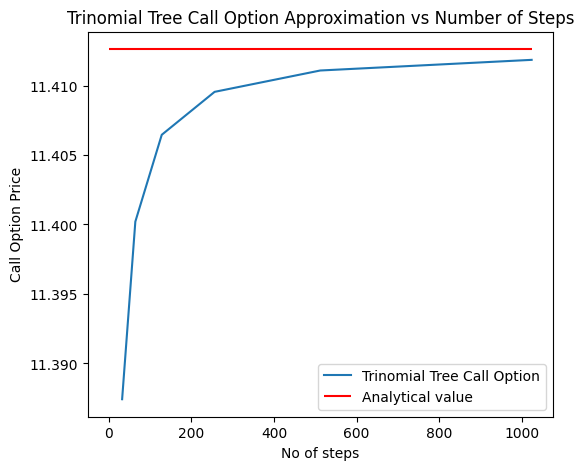

In [ ]:
checkConvergence(derivativeName='Call', derivativePayoff= lambda x : EuropeanCallOptionPayoff(x,K),analyticalValue= BSMcall(S0, K, T, 0, r, q, sigma), TreeClass = TrinomialTree)